데이터셋: Personal Loan 
- toal 14 variables
- ID,ZIP Code 제외
- target variable : Personal loan

목적 : Post-Purning vs Pre-Purning 성능 비교 

1. 모듈 불러오기

In [82]:
#데이터 전처리 패키지 
import numpy as np 
import pandas as pd 

#기계학습 모델 구축 및 평가 패키지 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_graphviz
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve

#데이터 시각화 패키지 
from matplotlib import pyplot as plt  
%matplotlib inline

#warning 무시
import warnings
warnings.filterwarnings(action='ignore')

#한글 폰트 설정
plt.rc('font',family='Malgun Gothic')

2. 평가(성능)지표 생성

In [83]:
#Performance Evaluation Function
def perf_eval(cm):
    _tp = cm[1,1]
    _fn = cm[1,0]
    _fp = cm[0,1]
    _tn = cm[0,0]
    
    #True positive rate (TPR)
    TPR = _tp / (_tp + _fn)
    #Precision
    PRE = _tp / (_tp + _fp)
    #True negative rate (TNR)
    TNR = _tn / (_tn + _fp)
    #Simple Accuracy
    ACC = (_tp+_tn) / np.sum(cm)
    #Balanced Correction Rate
    BCR = np.sqrt(TPR*TNR)
    #F1-Measure
    F1 = 2*TPR*PRE/(TPR+PRE)
    
    return TPR,PRE,TNR,ACC,BCR,F1

In [84]:
#Performance table
Perf_Table = pd.DataFrame(index=['Post-Pruning','Pre-Pruning'],columns=["TPR","Precision","TNR","Accuracy","BCR","F1-Measure"])

In [85]:
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
Post-Pruning,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN


3. 데이터셋 불러옴 

In [86]:
#Load data - Preprocessing
Ploan=pd.read_csv("Personal Loan.csv")
columns=Ploan.columns.values
input_idx=[1,2,3,5,6,7,8,10,11,12,13]
target_idx= 9 
Ploan_input=Ploan[columns[input_idx]]
Ploan_target=Ploan[columns[target_idx]]

In [87]:
Ploan_input , Ploan_target

(      Age  Experience  Income  Family  CCAvg  Education  Mortgage  \
 0      25           1      49       4    1.6          1         0   
 1      45          19      34       3    1.5          1         0   
 2      39          15      11       1    1.0          1         0   
 3      35           9     100       1    2.7          2         0   
 4      35           8      45       4    1.0          2         0   
 ...   ...         ...     ...     ...    ...        ...       ...   
 2495   46          22      70       4    1.9          1       212   
 2496   63          37      32       3    0.7          2       141   
 2497   33           9      14       3    0.9          3       114   
 2498   38          14     111       2    6.1          1       326   
 2499   53          27      38       4    2.8          2       144   
 
       Securities Account  CD Account  Online  CreditCard  
 0                      1           0       0           0  
 1                      1           0 

In [108]:
X_train,X_test,y_train,y_test = train_test_split(Ploan_input,Ploan_target,train_size=1500,random_state=12345) 

4.모델 구축 (CART)

In [109]:
#Classificaton and Regression Tree (CART)
clf = DecisionTreeClassifier(random_state=12345)
CART_post= clf.fit(X_train,y_train)

In [110]:
clf.score(X_train,y_train)

1.0

In [111]:
clf.score(X_test,y_test)

0.973

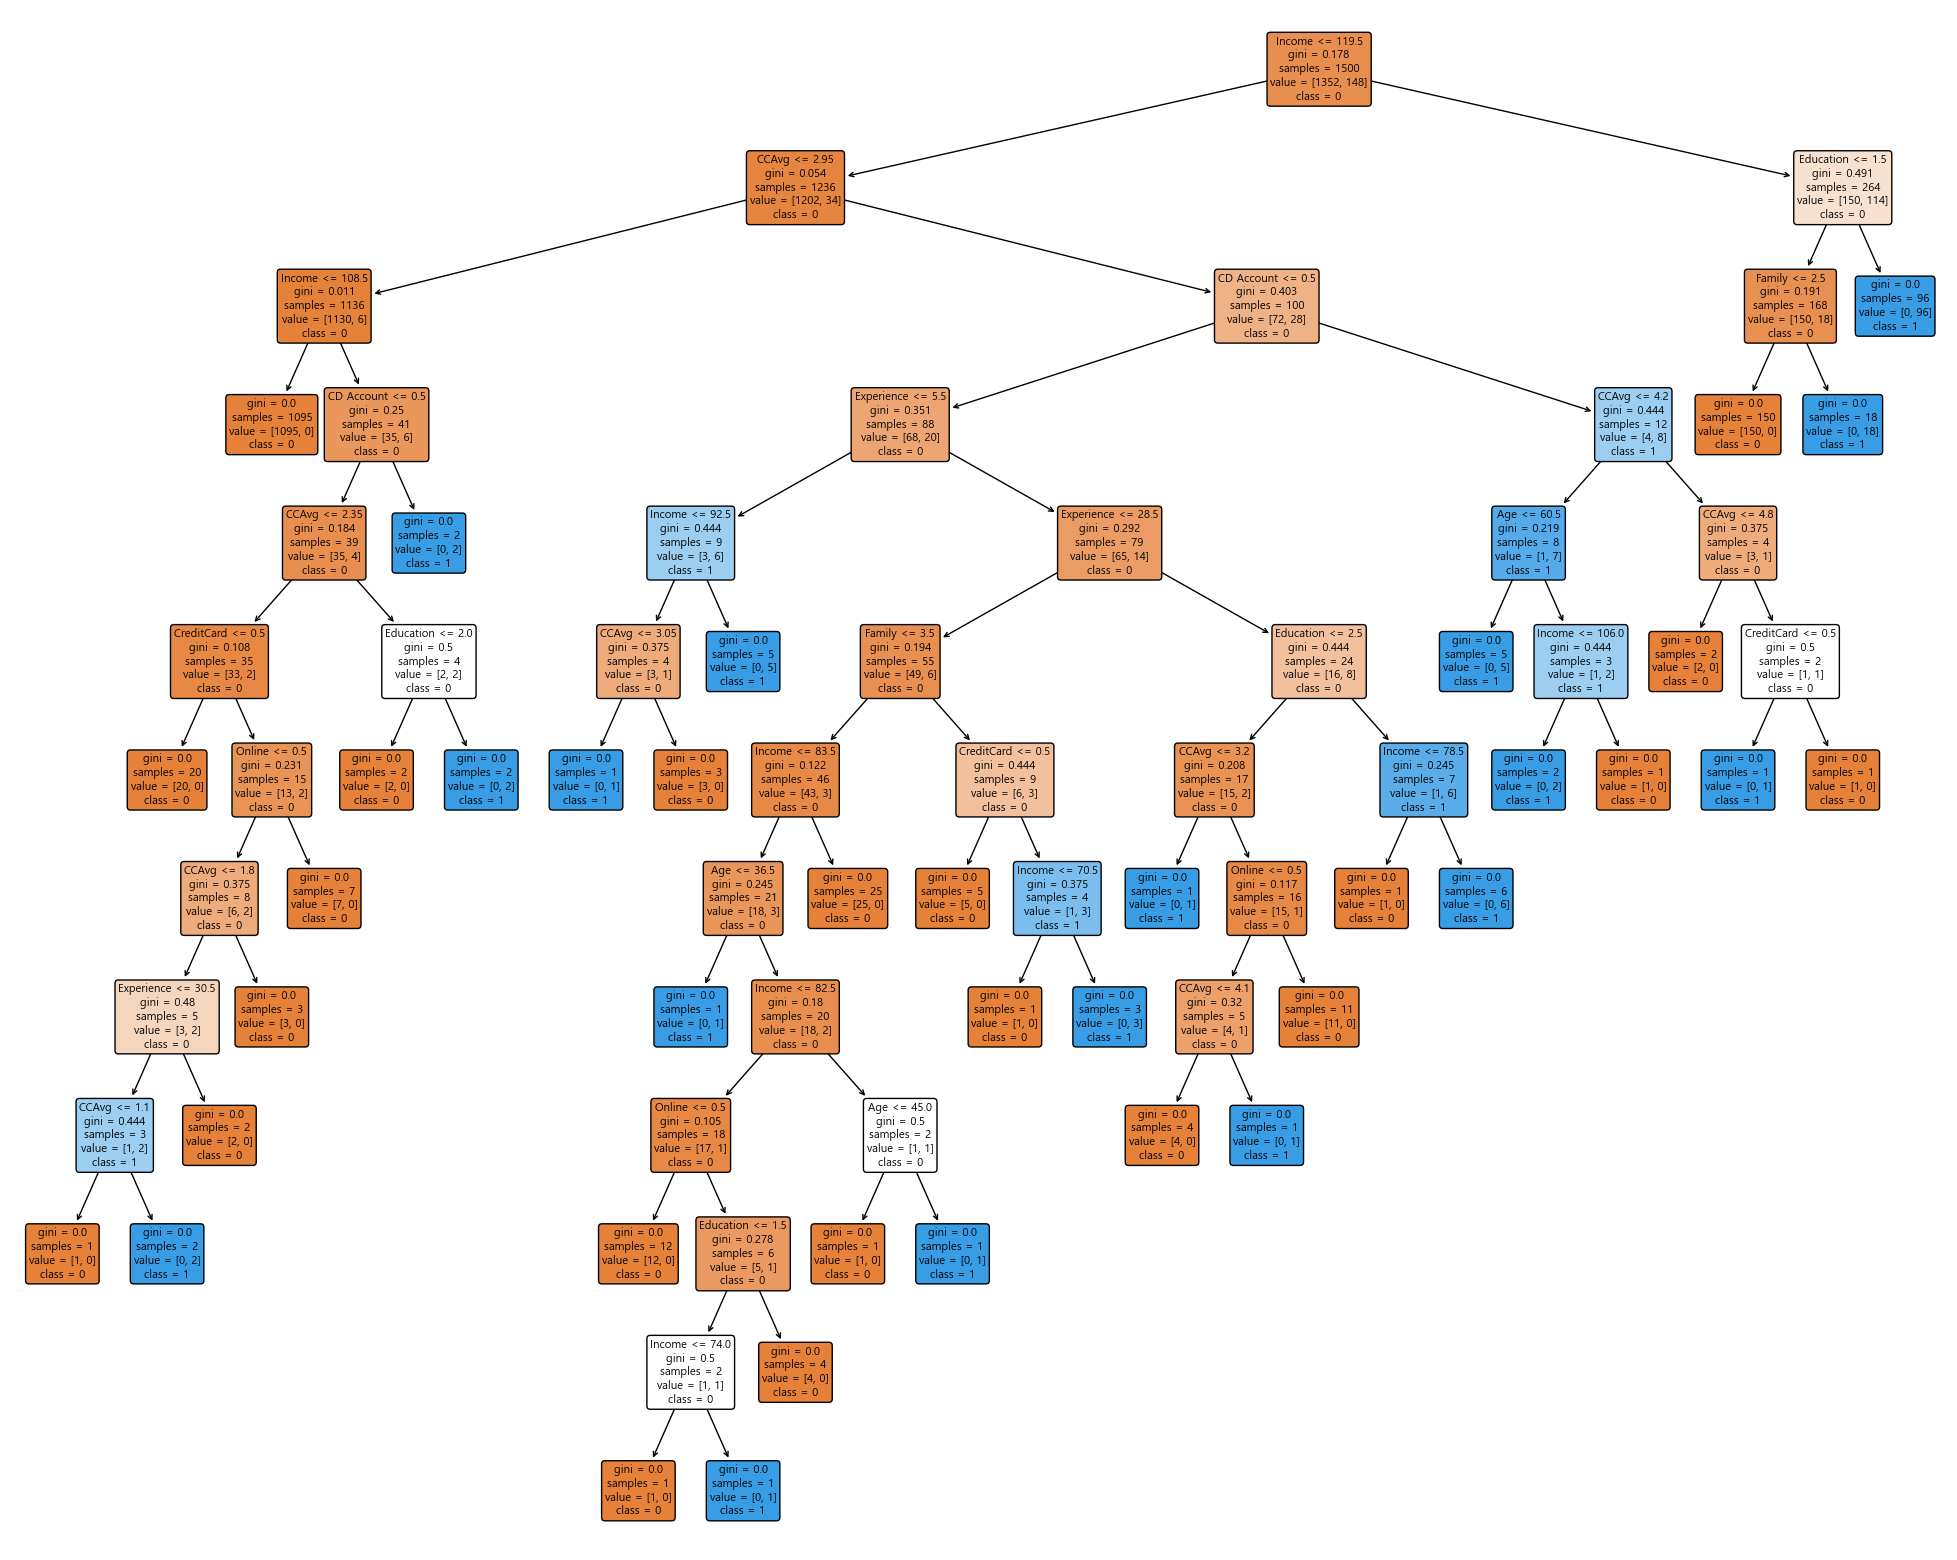

In [92]:
#plot the tree
fig=plt.figure(figsize=(25,20))
_=plot_tree(clf,
            feature_names=Ploan_input.columns.values,
            class_names=list(map(str,Ploan_target.unique())),
            rounded=True,
            filled =True 
           )
plt.show()

-> Find the best tree based on cost complexity pruning 

In [94]:
path=clf.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas,impurities=path.ccp_alphas,path.impurities

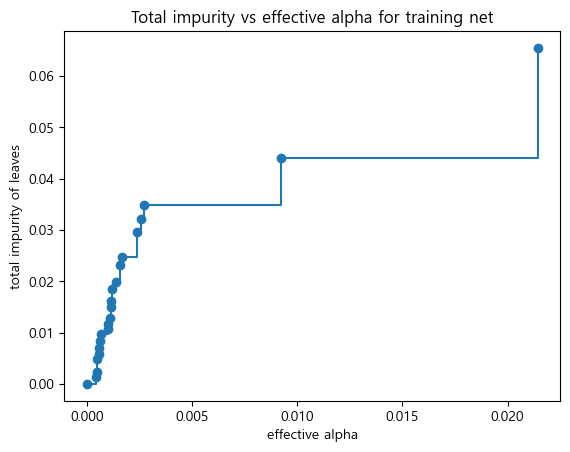

In [95]:
fig,ax= plt.subplots()
ax.plot(ccp_alphas[:-1],impurities[:-1],marker='o',drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title('Total impurity vs effective alpha for training net')
plt.show()

In [96]:
clfs=[]
for ccp_alpha in ccp_alphas:
    clf=DecisionTreeClassifier(random_state=12345,ccp_alpha=ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)
print(
    f"Number of nodes in the last tree is : {clfs[-1].tree_.node_count} with ccp_alpha : {ccp_alphas[-1]}"
)

Number of nodes in the last tree is : 1 with ccp_alpha : 0.056174119895207264


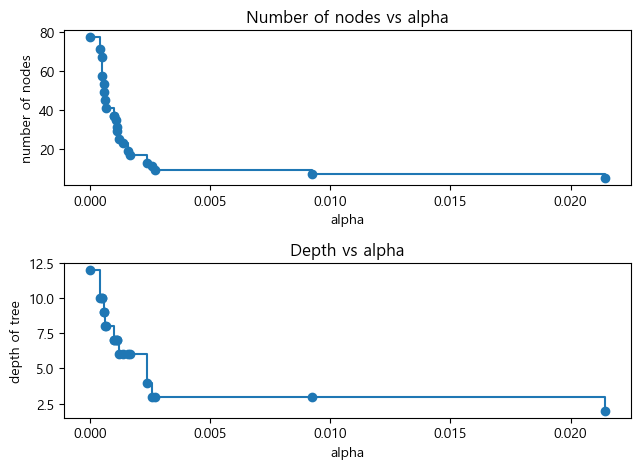

In [97]:
clfs=clfs[:-1]
ccp_alphas=ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig,ax =plt.subplots(2,1)
ax[0].plot(ccp_alphas,node_counts,marker='o',drawstyle='steps-post')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('number of nodes')
ax[0].set_title('Number of nodes vs alpha')
ax[1].plot(ccp_alphas,depth,marker='o',drawstyle='steps-post')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('depth of tree')
ax[1].set_title('Depth vs alpha')
fig.tight_layout()

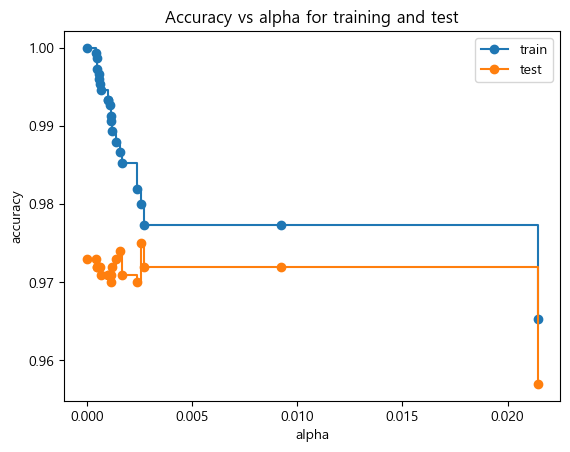

In [98]:
train_scores = [clf.score(X_train,y_train) for clf in clfs]
test_scores = [clf.score(X_test,y_test) for clf in clfs]

fig,ax=plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alpha for training and test')
ax.plot(ccp_alphas,train_scores,marker='o',label='train',drawstyle='steps-post')
ax.plot(ccp_alphas,test_scores,marker='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

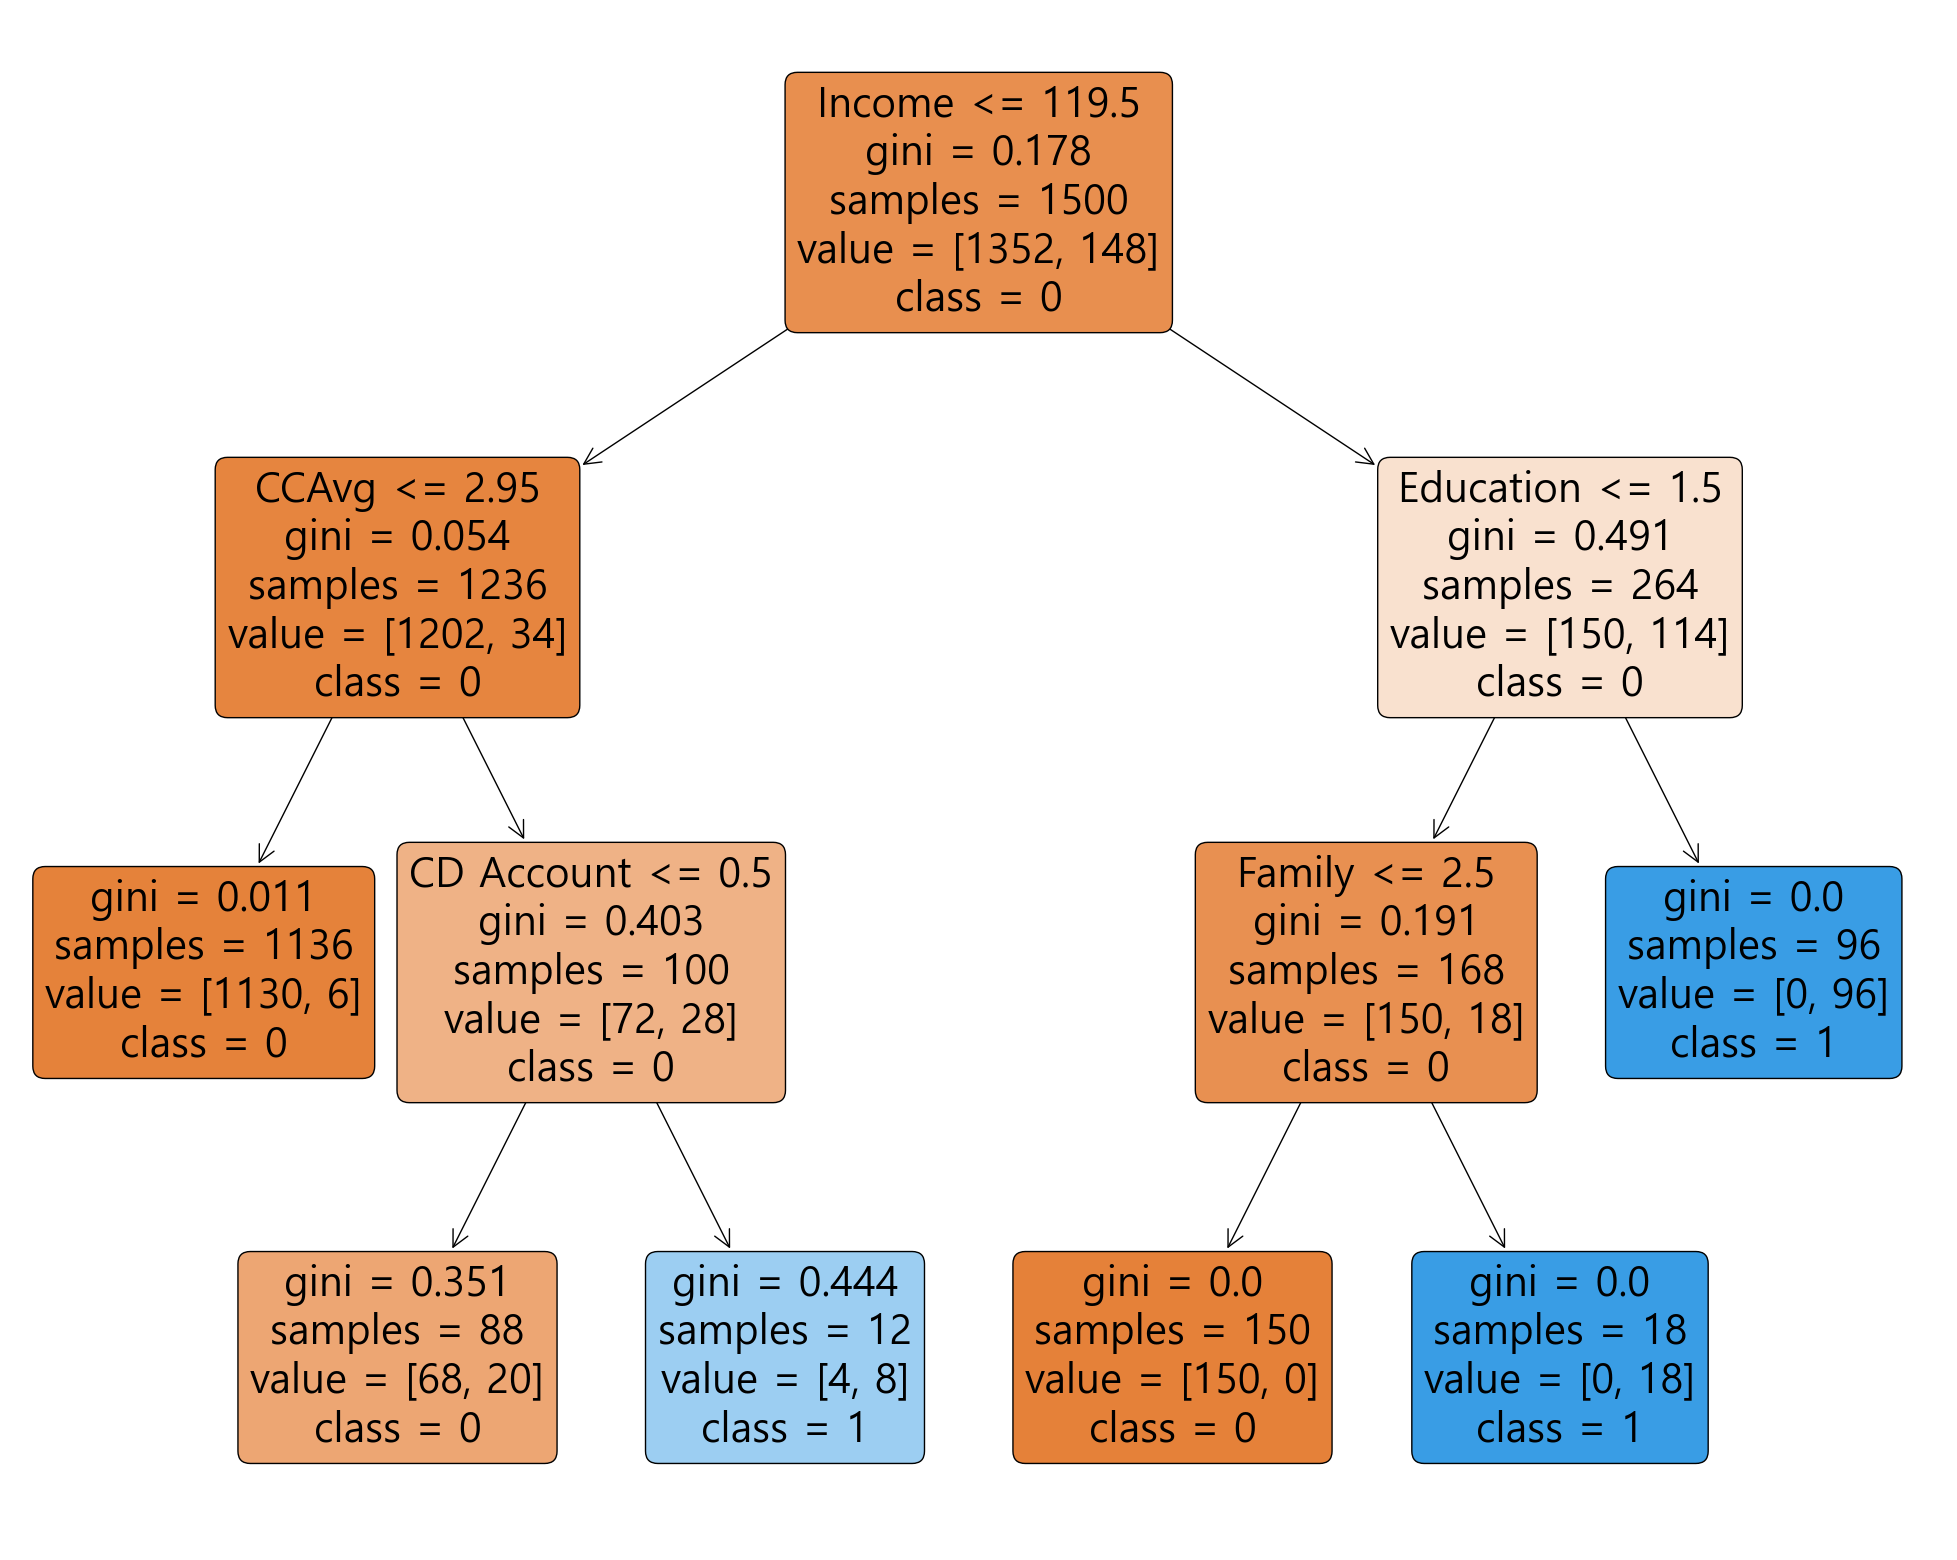

In [99]:
best_clf=clfs[np.argmax(test_scores)]

fig = plt.figure(figsize=(25,20))
_=plot_tree(best_clf,
            feature_names=Ploan_input.columns.values,
            class_names=list(map(str,Ploan_target.unique())),
            rounded=True,
            filled =True
)

In [100]:
#Prediction
CART_post_prey = best_clf.predict(X_test)
cm = confusion_matrix(y_test,CART_post_prey)
Perf_Table.iloc[0]=perf_eval(cm)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
Post-Pruning,0.787037,0.977011,0.997758,0.975,0.886156,0.871795
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN


1-2) Pre-Pruning 
- 파라미터 값 바꾸어 가면서 계산하는 것 

In [120]:
#Tree parameter settings 
criterion=['gini','entropy','log_loss']
min_split=[10,30,50]
max_depth=[1,5,10]

param_grid={
    'criterion':criterion,
    'min_samples_split':min_split,
    'max_depth':max_depth
    
}

In [121]:
#Find the decision tree model and evaluate the results 
model =DecisionTreeClassifier(random_state=12345)
grid = GridSearchCV(model,param_grid,cv=5,scoring='roc_auc',refit=True)
grid.fit(X_train,y_train)
#Find the best set of parameters
best_criterion = grid.best_params_['criterion']
best_split = grid.best_params_['min_samples_split']
best_depth = grid.best_params_['max_depth']

print('best criterion:',best_criterion)
print('best min_sample_split:',best_split)
print('best max_depth:',best_depth)

#Evaluate the best model on the validation data
y_pred= grid.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
roc=roc_auc_score(y_test,y_pred)
#print
print("Confusion matirix \n",cm)
print("ROC AUC",roc)

best criterion: entropy
best min_sample_split: 50
best max_depth: 5
Confusion matirix 
 [[887   5]
 [  8 100]]
ROC AUC 0.9601602723800035


In [122]:
#Prediciton
y_pred= grid.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
Perf_Table.iloc[1] = perf_eval(cm)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
Post-Pruning,0.787037,0.977011,0.997758,0.975,0.886156,0.871795
Pre-Pruning,0.925926,0.952381,0.994395,0.987,0.95955,0.938967
